# Set-Up

In [1]:
import warnings

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.io as pio
import umap
from factor_analyzer import FactorAnalyzer
from kagglehub import KaggleDatasetAdapter, dataset_load
from pandas.api.types import CategoricalDtype
from sklearn.cluster import HDBSCAN
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

pio.renderers.default = "notebook+png"

# Suppress UMAP job warning.
warnings.filterwarnings(
    action="ignore",
    message=".*n_jobs value 1 overridden.*"
)

# Suppress Factor Analysis deprecation warning.
warnings.filterwarnings(
    action="ignore",
    message=".*'force_all_finite' was renamed to 'ensure_all_finite'.*"
)

In [2]:
seed = 8675309
rng = np.random.default_rng(seed=seed)

# Data-Fetching

In [3]:
# Type hint added because dataset_load returns Any, but will return a DataFrame in this case, as we're using the adapter. This is just for convenience from the IDE (auto-complete, typo-checking, etc).
df: pd.DataFrame = dataset_load(
    adapter=KaggleDatasetAdapter.PANDAS,
    handle="miroslavsabo/young-people-survey",
    path="responses.csv",
)

# Exploration

In [4]:
df.describe()

,Music,Slow songs or fast songs,Dance,Folk,Country,Classical music,Musical,Pop,Rock,Metal or Hardrock,...,Shopping centres,Branded clothing,Entertainment spending,Spending on looks,Spending on gadgets,Spending on healthy eating,Age,Height,Weight,Number of siblings
count,1007.000000,1008.000000,1006.000000,1005.000000,1005.000000,1003.000000,1008.000000,1007.000000,1004.000000,1007.000000,...,1008.000000,1008.000000,1007.000000,1007.000000,1010.000000,1008.00000,1003.000000,990.000000,990.000000,1004.000000
mean,4.731877,3.328373,3.113320,2.288557,2.123383,2.956132,2.761905,3.471698,3.761952,2.361470,...,3.234127,3.050595,3.201589,3.106256,2.870297,3.55754,20.433699,173.514141,66.405051,1.297809
std,0.664049,0.833931,1.170568,1.138916,1.076136,1.252570,1.260845,1.161400,1.184861,1.372995,...,1.323062,1.306321,1.188947,1.205368,1.284970,1.09375,2.828840,10.024505,13.839561,1.013348
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,15.000000,62.000000,41.000000,0.000000
25%,5.000000,3.000000,2.000000,1.000000,1.000000,2.000000,2.000000,3.000000,3.000000,1.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,3.00000,19.000000,167.000000,55.000000,1.000000
50%,5.000000,3.000000,3.000000,2.000000,2.000000,3.000000,3.000000,4.000000,4.000000,2.000000,...,3.000000,3.000000,3.000000,3.000000,3.000000,4.00000,20.000000,173.000000,64.000000,1.000000
75%,5.000000,4.000000,4.000000,3.000000,3.000000,4.000000,4.000000,4.000000,5.000000,3.000000,...,4.000000,4.000000,4.000000,4.000000,4.000000,4.00000,22.000000,180.000000,75.000000,2.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.00000,30.000000,203.000000,165.000000,10.000000


In [5]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010 entries, 0 to 1009
Data columns (total 150 columns):
 #    Column                          Non-Null Count  Dtype  
---   ------                          --------------  -----  
 0    Music                           1007 non-null   float64
 1    Slow songs or fast songs        1008 non-null   float64
 2    Dance                           1006 non-null   float64
 3    Folk                            1005 non-null   float64
 4    Country                         1005 non-null   float64
 5    Classical music                 1003 non-null   float64
 6    Musical                         1008 non-null   float64
 7    Pop                             1007 non-null   float64
 8    Rock                            1004 non-null   float64
 9    Metal or Hardrock               1007 non-null   float64
 10   Punk                            1002 non-null   float64
 11   Hiphop, Rap                     1006 non-null   float64
 12   Reggae, Ska       

Most of the columns actually appear to be integers, and of those, most are Likert (1-5). Some object types are actually strings, which haven't been converted to categorical types, and will need to be done manually, as some are ordinal, and the ordering was probably lost.

# Cleaning

## Simple type conversion

In [6]:
df = df.convert_dtypes()

In [7]:
df.describe()

,Music,Slow songs or fast songs,Dance,Folk,Country,Classical music,Musical,Pop,Rock,Metal or Hardrock,...,Shopping centres,Branded clothing,Entertainment spending,Spending on looks,Spending on gadgets,Spending on healthy eating,Age,Height,Weight,Number of siblings
count,1007.0,1008.0,1006.0,1005.0,1005.0,1003.0,1008.0,1007.0,1004.0,1007.0,...,1008.0,1008.0,1007.0,1007.0,1010.0,1008.0,1003.0,990.0,990.0,1004.0
mean,4.731877,3.328373,3.11332,2.288557,2.123383,2.956132,2.761905,3.471698,3.761952,2.36147,...,3.234127,3.050595,3.201589,3.106256,2.870297,3.55754,20.433699,173.514141,66.405051,1.297809
std,0.664049,0.833931,1.170568,1.138916,1.076136,1.25257,1.260845,1.1614,1.184861,1.372995,...,1.323062,1.306321,1.188947,1.205368,1.28497,1.09375,2.82884,10.024505,13.839561,1.013348
min,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,15.0,62.0,41.0,0.0
25%,5.0,3.0,2.0,1.0,1.0,2.0,2.0,3.0,3.0,1.0,...,2.0,2.0,2.0,2.0,2.0,3.0,19.0,167.0,55.0,1.0
50%,5.0,3.0,3.0,2.0,2.0,3.0,3.0,4.0,4.0,2.0,...,3.0,3.0,3.0,3.0,3.0,4.0,20.0,173.0,64.0,1.0
75%,5.0,4.0,4.0,3.0,3.0,4.0,4.0,4.0,5.0,3.0,...,4.0,4.0,4.0,4.0,4.0,4.0,22.0,180.0,75.0,2.0
max,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,5.0,5.0,5.0,5.0,5.0,5.0,30.0,203.0,165.0,10.0


In [8]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010 entries, 0 to 1009
Data columns (total 150 columns):
 #    Column                          Non-Null Count  Dtype 
---   ------                          --------------  ----- 
 0    Music                           1007 non-null   Int64 
 1    Slow songs or fast songs        1008 non-null   Int64 
 2    Dance                           1006 non-null   Int64 
 3    Folk                            1005 non-null   Int64 
 4    Country                         1005 non-null   Int64 
 5    Classical music                 1003 non-null   Int64 
 6    Musical                         1008 non-null   Int64 
 7    Pop                             1007 non-null   Int64 
 8    Rock                            1004 non-null   Int64 
 9    Metal or Hardrock               1007 non-null   Int64 
 10   Punk                            1002 non-null   Int64 
 11   Hiphop, Rap                     1006 non-null   Int64 
 12   Reggae, Ska                     

## Rebuilding categories

The string-typed columns will need to be checked for the values they contain. There are only 11, so a hybrid eyeballing is optimal.

In [9]:
print(
    df.select_dtypes(include="string")
        .apply(
            lambda col: f"{col.name}\n" + "\n".join(f"  {v}" for v in col.unique())
        )
        .str
        .cat(sep="\n\n")
)

Smoking
  never smoked
  tried smoking
  former smoker
  current smoker
  <NA>

Alcohol
  drink a lot
  social drinker
  never
  <NA>

Punctuality
  i am always on time
  i am often early
  i am often running late
  <NA>

Lying
  never
  sometimes
  only to avoid hurting someone
  everytime it suits me
  <NA>

Internet usage
  few hours a day
  most of the day
  less than an hour a day
  no time at all

Gender
  female
  male
  <NA>

Left - right handed
  right handed
  left handed
  <NA>

Education
  college/bachelor degree
  secondary school
  primary school
  masters degree
  doctorate degree
  currently a primary school pupil
  <NA>

Only child
  no
  yes
  <NA>

Village - town
  village
  city
  <NA>

House - block of flats
  block of flats
  house/bungalow
  <NA>


The columns appear to be very clean. The only issue is most of these columns are obviously ordinal, and that information was lost, so it has to be manually defined.

In [10]:
df["Smoking"] = df["Smoking"].astype(CategoricalDtype(
    categories=[
        "never smoked",
        "tried smoking",
        "former smoker",
        "current smoker",
    ],
    ordered=True,
))

df["Alcohol"] = df["Alcohol"].astype(CategoricalDtype(
    categories=[
        "never",
        "social drinker",
        "drink a lot",
    ],
    ordered=True,
))

df["Punctuality"] = df["Punctuality"].astype(CategoricalDtype(
    categories=[
        "i am often running late",
        "i am often early",
        "i am always on time",
    ],
    ordered=True,
))

df["Lying"] = df["Lying"].astype(CategoricalDtype(
    categories=[
        "never",
        "sometimes",
        "only to avoid hurting someone",
        "everytime it suits me",
    ],
    ordered=True,
))

df["Internet usage"] = df["Internet usage"].astype(CategoricalDtype(
    categories=[
        "no time at all",
        "less than an hour a day",
        "few hours a day",
        "most of the day",
    ],
    ordered=True,
))

df["Gender"] = df["Gender"].astype(CategoricalDtype(
    categories=[
        "female",
        "male",
    ],
    ordered=False,
))

df["Left - right handed"] = df["Left - right handed"].astype(CategoricalDtype(
    categories=[
        "left handed",
        "right handed",
    ],
    ordered=False,
))

df["Education"] = df["Education"].astype(CategoricalDtype(
    categories=[
        "currently a primary school pupil",
        "primary school",
        "secondary school",
        "college/bachelor degree",
        "masters degree",
        "doctorate degree",
    ],
    ordered=True,
))

df["Only child"] = df["Only child"].astype(CategoricalDtype(
    categories=[
        "no",
        "yes",
    ],
    ordered=False,
))

df["Village - town"] = df["Village - town"].astype(CategoricalDtype(
    categories=[
        "village",
        "city",
    ],
    ordered=False,
))

df["House - block of flats"] = df["House - block of flats"].astype(CategoricalDtype(
    categories=[
        "block of flats",
        "house/bungalow",
    ],
    ordered=False,
))

In [11]:
df.select_dtypes("category").describe()

,Smoking,Alcohol,Punctuality,Lying,Internet usage,Gender,Left - right handed,Education,Only child,Village - town,House - block of flats
count,1002,1005,1008,1008,1010,1004,1007,1009,1008,1006,1006
unique,4,3,3,4,4,2,2,6,2,2,2
top,tried smoking,social drinker,i am always on time,sometimes,few hours a day,female,right handed,secondary school,no,city,block of flats
freq,430,659,399,549,744,593,906,621,754,707,595


In [12]:
df.select_dtypes("category").info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010 entries, 0 to 1009
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   Smoking                 1002 non-null   category
 1   Alcohol                 1005 non-null   category
 2   Punctuality             1008 non-null   category
 3   Lying                   1008 non-null   category
 4   Internet usage          1010 non-null   category
 5   Gender                  1004 non-null   category
 6   Left - right handed     1007 non-null   category
 7   Education               1009 non-null   category
 8   Only child              1008 non-null   category
 9   Village - town          1006 non-null   category
 10  House - block of flats  1006 non-null   category
dtypes: category(11)
memory usage: 12.7 KB


## Filling NA for clustering

### Splitting column types for different fill methods

In [13]:
# Integer columns that are non-Likert.
integer_cols = ["Age", "Height", "Weight", "Number of siblings"]

# Integer columns that are Likert.
likert_cols = list(df.select_dtypes("number").columns.difference(integer_cols))

category_cols = [c for c in df.columns if isinstance(df[c].dtype, CategoricalDtype)]

ordinal_cols = [c for c in category_cols if df[c].dtype.ordered]

nominal_cols = list(set(category_cols).difference(ordinal_cols))

### Fill based on column type

In [14]:
# We might want to revisit this to fill base on gender.

# Note: Converts all int columns to float columns.
# This allows for interpolated values.
df[integer_cols] = df[integer_cols]\
    .astype(float)\
    .fillna(df[integer_cols].median())

# Note: Converts all likert columns to float columns.
# This allows for interpolated values.
# We should consider probabilistic median rounding if normal rounding proves to be an issue.
df[likert_cols] = df[likert_cols]\
    .astype(float)\
    .fillna(df[likert_cols].median())

# Fill NA with the median response for each ordinal category, treating ordinals numerically.
df[ordinal_cols] = df[ordinal_cols].fillna(
    df[ordinal_cols].apply(
        lambda c: c.cat.categories[
            round(c.cat.codes.replace(-1, np.nan).median())
        ]
    )
)

df[nominal_cols] = df[nominal_cols].fillna(df[nominal_cols].mode().iloc[0])

### Check for NA

In [15]:
df.isna().any().any()

np.False_

# Analysis

## Data Transformation

### Jitter

Because the data is Likert (a small, discrete grid), many algorithms are assisted by adding a small amount of noise.

In [16]:
jitter_size = 0.1
df_jit = df[likert_cols] + rng.random(df[likert_cols].shape)*jitter_size - jitter_size

### Scaling

In [17]:
std_scaler = StandardScaler()

df_trans = df_jit\
    .pipe(lambda d: d.assign(**dict(zip(
        likert_cols,
        std_scaler.fit_transform(d).T
    ))))


## Feature Selection with Factor Analysis

### Scree Elbow Plot

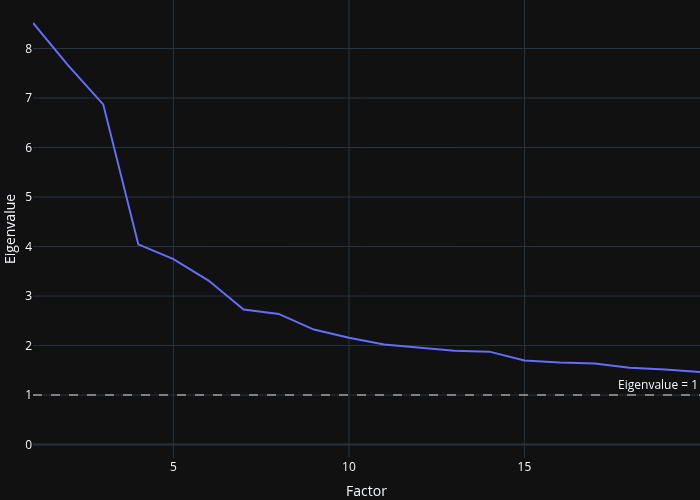

In [18]:
fig = px.line(
    pd.DataFrame(dict(
        factor=range(1, len(df_trans.columns)+1),
        eigenvalue=FactorAnalyzer(rotation=None)\
            .fit(df_trans)\
            .get_eigenvalues()\
            [0],
    )),
    x="factor",
    y="eigenvalue",
    labels=dict(
        factor="Factor",
        eigenvalue="Eigenvalue",
    )
)

fig.add_hline(
    y=1,
    line_dash="dash",
    line_color="grey",
    annotation_text="Eigenvalue = 1"
)

fig.update_layout(margin=dict(l=0, r=0, t=0, b=0))
fig.update_xaxes(automargin=True)
fig.update_yaxes(automargin=True)
fig.update_xaxes(range=[1, 20])
fig.show()

The elbow is sufficiently deep, though not so well-defined. Additionally, the curve still sits above 1 even as far out as 20 factors. Rather than choosing an elbow value, it will probably be better to pick a value farther right.

### Calculate Loadings

In [19]:
# 9 seemed to be the most reasonable quantity, after trying a few values.
n_factors = 9
fa = FactorAnalyzer(
    n_factors=n_factors,
    rotation="varimax",
)
fa.fit(df_trans)

loadings = pd.DataFrame(
    fa.loadings_,
    index=df_trans.columns,
    columns=[f"factor_{i}" for i in range(n_factors)],
)
loadings

,factor_0,factor_1,factor_2,factor_3,factor_4,factor_5,factor_6,factor_7,factor_8
Achievements,0.008600,0.075915,0.065726,0.019776,0.208946,0.000283,-0.101423,-0.001106,-0.001528
Action,-0.050405,0.549320,0.074846,-0.123052,0.035160,0.019144,-0.003224,-0.009828,-0.099670
Active sport,0.019674,0.246361,0.362387,-0.045789,0.128845,0.010779,0.000126,-0.017223,0.164039
Adrenaline sports,0.017190,0.311907,0.307404,-0.177852,0.263678,0.053078,-0.109574,0.058325,0.172386
Ageing,-0.054208,-0.065861,-0.131656,0.321273,0.238189,0.068551,-0.023243,0.057276,0.039534
...,...,...,...,...,...,...,...,...,...
War,0.148402,0.415991,0.063383,-0.169078,0.045438,-0.134031,-0.032177,0.080640,-0.117931
Western,0.249922,0.461379,0.096661,-0.103165,-0.098530,-0.117783,-0.007978,0.078888,-0.026368
Workaholism,0.237388,-0.051691,0.034687,0.030640,0.078046,-0.094676,0.476059,0.075030,0.134319
Writing,0.431998,-0.094570,-0.110047,0.079240,0.080008,-0.045663,-0.004916,0.090744,0.065158


### Top 3 Questions for Each Factor

In [20]:
df_factor_top_questions = loadings.apply(lambda c: pd.Series(
    data=[
        item
        for q_l_pair in zip(c.nlargest(3).index, c.nlargest(3).values)
        for item in q_l_pair
    ],
    index="Question_0 Loading_0 Question_1 Loading_1 Question_2 Loading_2".split(),
)).T
df_factor_top_questions

,Question_0,Loading_0,Question_1,Loading_1,Question_2,Loading_2
factor_0,Classical music,0.635892,Opera,0.587488,"Swing, Jazz",0.51705
factor_1,PC,0.615,Action,0.54932,Cars,0.544479
factor_2,Energy levels,0.666887,Number of friends,0.573197,Happiness in life,0.56388
factor_3,Storm,0.585222,Rats,0.55636,Snakes,0.552635
factor_4,Spending on looks,0.607757,Knowing the right people,0.463058,Branded clothing,0.459681
factor_5,Fantasy/Fairy tales,0.518846,Animated,0.491925,Romantic,0.42434
factor_6,Prioritising workload,0.515698,Reliability,0.508128,Thinking ahead,0.497584
factor_7,Rock,0.615343,Punk,0.605103,Metal or Hardrock,0.597543
factor_8,Biology,0.741991,Chemistry,0.706881,Medicine,0.634167


### Save Top Question of Each Factor

In [21]:
survey_questions = df_factor_top_questions["Question_0"].tolist()
df_reduced = df_trans[survey_questions].copy()

survey_questions

['Classical music',
 'PC',
 'Energy levels',
 'Storm',
 'Spending on looks',
 'Fantasy/Fairy tales',
 'Prioritising workload',
 'Rock',
 'Biology']

## Clustering

#### Elbow Method for K

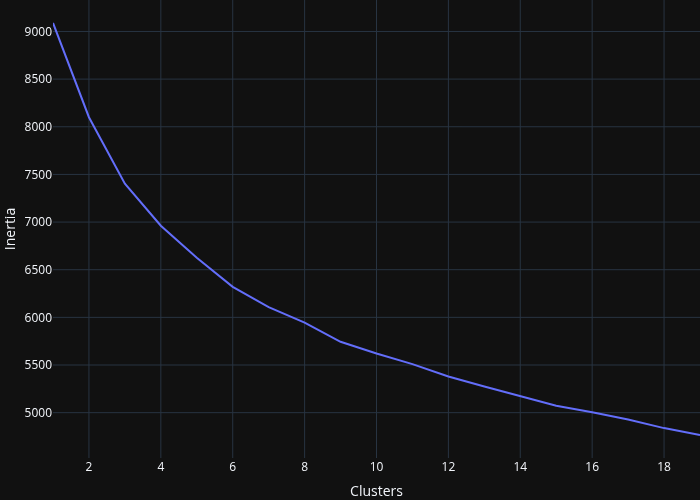

In [22]:
k_range = range(1, 20)

fig = px.line(
    x=k_range,
    y=[
        KMeans(
            n_clusters=k,
            random_state=seed,
            n_init=10
        )
            .fit(df_reduced)
            .inertia_
        for k in k_range
    ],
    labels=dict(
        x="Clusters",
        y="Inertia",
    ),
)
fig.update_layout(margin=dict(l=0, r=0, t=0, b=0))
fig.update_xaxes(automargin=True)
fig.update_yaxes(automargin=True)
fig.show()

The elbow is not so well-defined. This is likely a result of the values being Likert.

#### Checking UMAP

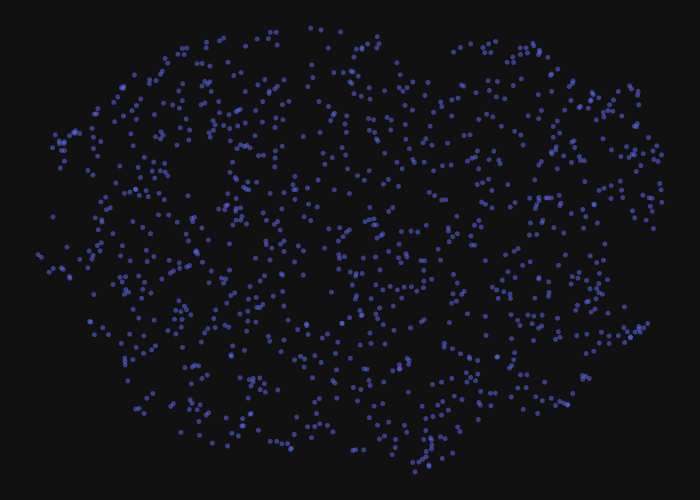

In [23]:
umap_2d_embedding = umap\
    .UMAP(
        n_neighbors=15,
        min_dist=0.1,
        n_components=2,
        random_state=seed,
    )\
    .fit_transform(df_reduced)

fig = px.scatter(
    x=umap_2d_embedding[:, 0],
    y=umap_2d_embedding[:, 1],
    opacity=0.5,
)
fig.update_traces(marker_size=5)
fig.update_layout(margin=dict(l=0, r=0, t=0, b=0))
fig.update_xaxes(visible=False)
fig.update_yaxes(visible=False)
fig.show()

Very much a blob, but there are areas of sparsity through the blob which denote some clustering structure, even if only a little.

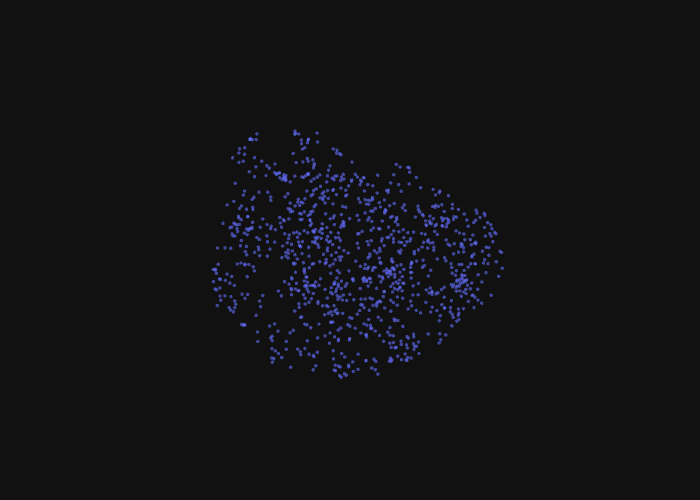

In [24]:
umap_3d_embedding = umap\
    .UMAP(
        n_neighbors=15,
        min_dist=0.1,
        n_components=3,
        random_state=seed,
    )\
    .fit_transform(df_reduced)

fig = px.scatter_3d(
    x=umap_3d_embedding[:, 0],
    y=umap_3d_embedding[:, 1],
    z=umap_3d_embedding[:, 2],
    opacity=0.6,
)

fig.update_traces(marker_size=2)
fig.update_layout(margin=dict(l=0, r=0, t=0, b=0))
fig.update_scenes(
    xaxis_visible=False,
    yaxis_visible=False,
    zaxis_visible=False
)

fig.show()

A similar story to the 2d plot.

#### Checking T-SNE

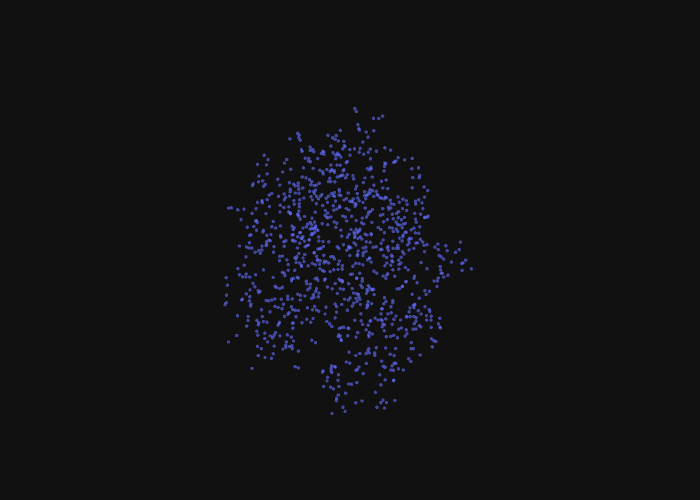

In [25]:
tsne_3d_embedding = TSNE(
    n_components=3,
    perplexity=15,
    random_state=seed,
    n_jobs=-1
).fit_transform(df_reduced)

fig = px.scatter_3d(
    x=tsne_3d_embedding[:, 0],
    y=tsne_3d_embedding[:, 1],
    z=tsne_3d_embedding[:, 2],
    opacity=0.6
)
fig.update_traces(marker_size=2)
fig.update_layout(margin=dict(l=0, r=0, t=0, b=0))
fig.update_scenes(
    xaxis_visible=False,
    yaxis_visible=False,
    zaxis_visible=False
)

fig.show()

And the same for t-SNE

#### Check Nearest Neighbors Curve

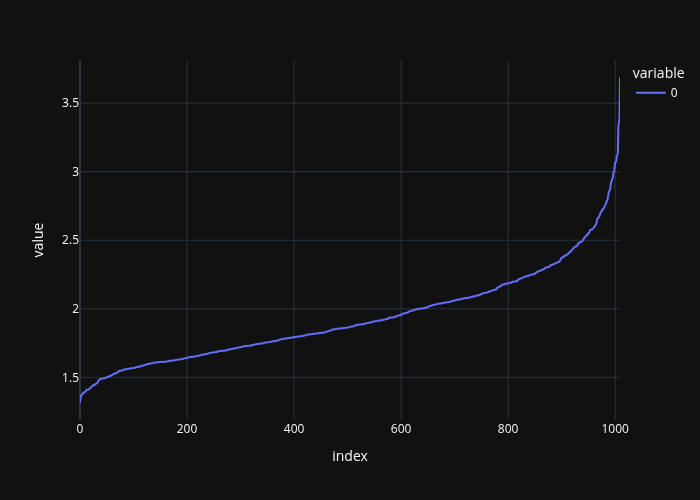

In [26]:
px.line(np.sort(
    NearestNeighbors(n_neighbors=6)\
        .fit(df_reduced)\
        .kneighbors(df_reduced)\
        [0]\
        [:, 5]
))

The neighbor curve is not sharp enough. It's very unlikely any real clusters exist.

#### Checking HDBSCAN (with UMAP embedding)

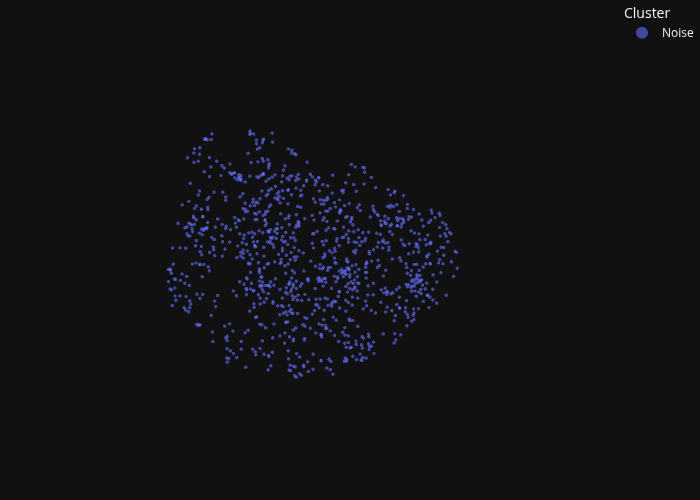

In [27]:
hdbscan = HDBSCAN(
    min_cluster_size=50,
    min_samples=15,
)
hdbscan_labels = hdbscan.fit_predict(df_reduced)

df_hbdscan = pd.DataFrame(dict(
    UMAP_0=umap_3d_embedding[:, 0],
    UMAP_1=umap_3d_embedding[:, 1],
    UMAP_2=umap_3d_embedding[:, 2],
    Cluster=np.char.replace(hdbscan_labels.astype(str), "-1", "Noise"),
    Probability=hdbscan.probabilities_,
))

fig = px.scatter_3d(
    df_hbdscan,
    x="UMAP_0",
    y="UMAP_1",
    z="UMAP_2",
    color="Cluster",
    size="Probability",
    size_max=10,
    hover_data=["Probability"],
    opacity=0.6,
)
fig.update_traces(marker_size=2)
fig.update_layout(margin=dict(l=0, r=0, t=0, b=0))
fig.update_scenes(
    xaxis_visible=False,
    yaxis_visible=False,
    zaxis_visible=False
)

fig.show()

HDBSCAN failing to find clusters is sufficient proof this dataset has no well-defined clusters. Apparently, this is typical for Likert survey data.

# Moving Forward

## Reflection

Although there are no clusters within the data, this doesn't mean the data is useless. Factor analysis revealed a kind of clustering of how individuals answer related questions. At the very least, these questions can be used to create the reduced survey. Further, no clusters (in this case) means we will need to hold onto the exact values for each question when a user takes the reduced survey. Because the plan is to use a LLM for the next step of recommendation, this proves not to be too much of an issue.

## Personality Factor Descriptions

Google Gemini was asked to:
1. Give each personality factor a title or name.
2. Make a one sentence description with regard to what it says about someone's personality in a general sense.
3. Predict which kind of stocks and financial assets would interest such an individual with this personality feature.

#### Factor 0: The Cultural Connoisseur
* **Key Drivers:** Classical music, Opera, Swing/Jazz
* **Personality:** This individual possesses a sophisticated and open mindset, valuing history, complexity, and aesthetic depth over fleeting trends.
* **Financial Profile:** **Value Investing & "Old Money"**
    * They prefer assets with history and prestige.
    * *Picks:* Blue-chip dividend stocks (e.g., Coca-Cola, J.P. Morgan), Art Investment Funds (e.g., Masterworks), or luxury conglomerates like LVMH.

#### Factor 1: The Tech & Thrill Seeker
* **Key Drivers:** PC, Action, Cars
* **Personality:** High in sensation-seeking and mechanically inclined, this person enjoys performance, adrenaline, and complex digital systems.
* **Financial Profile:** **High-Growth Tech & Volatility**
    * They are comfortable with risk if the performance upside is high.
    * *Picks:* Semiconductor stocks (NVIDIA, AMD), EV manufacturers (Tesla), and high-risk assets like Cryptocurrency.

#### Factor 2: The Social Optimist
* **Key Drivers:** Energy levels, Number of friends, Happiness in life
* **Personality:** A highly extroverted and stable individual who thrives on social connection and maintains a generally positive, energetic outlook on life.
* **Financial Profile:** **Consumer Discretionary & Trends**
    * They invest in things that facilitate connection and enjoyment.
    * *Picks:* Social media giants (Meta, Snap), Hospitality/Travel (Airbnb, Marriott), and ESG funds that align with a positive worldview.

#### Factor 3: The Anxious Observer
* **Key Drivers:** Storm, Rats, Snakes
* **Personality:** This profile suggests a higher sensitivity to threats (neuroticism); they are likely cautious, vigilant, and hyper-aware of risks in their environment.
* **Financial Profile:** **Capital Preservation & Hedging**
    * They prioritize safety and protection against "black swan" events.
    * *Picks:* Gold (the classic fear trade), Insurance companies (UnitedHealth, Allstate), Government Bonds, and Cybersecurity stocks.

#### Factor 4: The Status Strategist
* **Key Drivers:** Spending on looks, Knowing the right people, Branded clothing
* **Personality:** An image-conscious individual who understands social hierarchy and views appearance and networking as essential tools for success.
* **Financial Profile:** **Luxury Retail & Exclusive Assets**
    * They understand brand equity and social signaling.
    * *Picks:* High-end fashion (Kering, Hermès), Private Equity (for the exclusivity), or hype-driven stocks where social sentiment drives value.

#### Factor 5: The Romantic Dreamer
* **Key Drivers:** Fantasy/Fairy tales, Animated, Romantic
* **Personality:** An imaginative and empathetic person who often prefers idealism, narrative, and emotional resonance over cold, hard logic.
* **Financial Profile:** **Entertainment & "Story Stocks"**
    * They buy into the vision and the narrative rather than just the balance sheet.
    * *Picks:* Media giants (Disney, Netflix), Nintendo (nostalgia play), and visionary companies (e.g., Space exploration stocks).

#### Factor 6: The Prudent Planner
* **Key Drivers:** Prioritising workload, Reliability, Thinking ahead
* **Personality:** Highly conscientious and organized, this person values structure, dutifully meets obligations, and always has a long-term strategy.
* **Financial Profile:** **Passive Indexing & Dividends**
    * They want predictable, steady compounding without drama.
    * *Picks:* S&P 500 Index Funds (VOO), Target Date Retirement Funds, and "Dividend Aristocrats" (companies with 25+ years of payout growth).

#### Factor 7: The Counter-Culture Rebel
* **Key Drivers:** Rock, Punk, Metal or Hardrock
* **Personality:** Non-conformist and intense, this individual likely questions authority and possesses a high tolerance for chaos or aggressive expression.
* **Financial Profile:** **Contrarian & Anti-Establishment**
    * They like betting against the system or finding value in rejected sectors.
    * *Picks:* Decentralized Finance (DeFi), Cannabis stocks, Short-selling strategies, or Emerging Markets.

#### Factor 8: The Empirical Analyst
* **Key Drivers:** Biology, Chemistry, Medicine
* **Personality:** An analytical thinker who values objective truth, the scientific method, and education; they trust data over intuition.
* **Financial Profile:** **Biotech & R&D**
    * They invest in innovation that can be proven and measured.
    * *Picks:* Pharmaceutical giants (Pfizer, Merck), Biotech ETFs (IBB), Medical Devices (Thermo Fisher), and Clean Energy tech.